In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf
from skimage import exposure
from skimage.color import rgb2gray
keras = tf.keras

In [0]:
model = keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(224,224,3), weights='imagenet')

In [0]:
def preprocess(image):
    gray = rgb2gray(image)
    hist = exposure.equalize_hist(image)
    return hist

In [0]:
%%time
preprocessor = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess,
                                                           validation_split=0.2)
training_data = preprocessor.flow_from_directory("E:/Jupyter/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/",
                                        target_size=(224, 224),
                                       subset='training')
val_data = preprocessor.flow_from_directory("E:/Jupyter/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/",
                                        target_size=(224, 224),
                                       subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Wall time: 1.92 s


In [0]:
%%time
features = model(training_data[0][0])
print(features.shape)

E:\Anaconda3\envs\myenv\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


(32, 7, 7, 2048)
Wall time: 2.17 s


In [0]:
model.trainable = False
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [0]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(features)
print(feature_batch_average.shape)

(32, 2048)


In [0]:
prediction_layer = keras.layers.Dense(43, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 43)


In [0]:
assembled_model = tf.keras.Sequential([
  model,
  global_average_layer,
  prediction_layer
])

In [0]:
assembled_model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
loss0,accuracy0 = assembled_model.evaluate(val_data, steps = 20, verbose=1)

  ...
    to  
  ['...']
20/20 [==============================] - 28s 1s/step - loss: 4.2424 - accuracy: 0.0453


In [0]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.24
initial accuracy: 0.05


In [0]:
%%time
history = assembled_model.fit(training_data,
                    epochs=10,
                    validation_data=val_data)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 981 steps, validate for 246 steps
Epoch 1/10


E:\Anaconda3\envs\myenv\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


981/981 [==============================] - 4281s 4s/step - loss: 1.9713 - accuracy: 0.4748 - val_loss: 2.5393 - val_accuracy: 0.3051
Epoch 2/10
981/981 [==============================] - 4272s 4s/step - loss: 1.0404 - accuracy: 0.7104 - val_loss: 2.8544 - val_accuracy: 0.3007
Epoch 3/10
981/981 [==============================] - 4273s 4s/step - loss: 0.7991 - accuracy: 0.7733 - val_loss: 3.0467 - val_accuracy: 0.3079
Epoch 4/10
981/981 [==============================] - 4276s 4s/step - loss: 0.6729 - accuracy: 0.8062 - val_loss: 3.2366 - val_accuracy: 0.3123
Epoch 5/10
981/981 [==============================] - 4278s 4s/step - loss: 0.5931 - accuracy: 0.8263 - val_loss: 3.3876 - val_accuracy: 0.3123
Epoch 6/10
981/981 [==============================] - 4272s 4s/step - loss: 0.5362 - accuracy: 0.8431 - val_loss: 3.5552 - val_accuracy: 0.3104
Epoch 7/10
981/981 [==============================] - 4273s 4s/step - loss: 0.4929 - accuracy: 0.8566 - val_loss: 3.6388 - val_accuracy: 0.3150
Epo

In [0]:
assembled_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 43)                88107     
Total params: 23,652,907
Trainable params: 88,107
Non-trainable params: 23,564,800
_________________________________________________________________


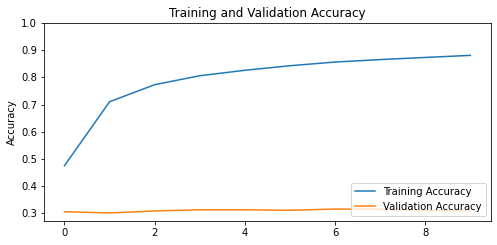

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

Using Tensorflow Keras, transfer learning was implemented using a ResNetv2 50 pre-trained on Google's ImageNet image recognition dataset, sequentially layered with a global averaging layer and a prediction (output) layer. Output layer was one-hot encoded to 43 outputs, activation function was softmax, loss function was categorical cross-entropy, and optimization was Adam. Test data set was split into 80% test and 20% validation and shuffled. Initial loss and accuracy were 4.24 and 0.05, respectively. Training was done over two epochs because it takes around 3 hours for a single epoch to complete on dev platform. Final training loss and accuracy were 0.4065 and 0.8812, respectively. Final validation loss and accuracy were 4.0025 and 0.3100, respectively.